In [1]:
using BenchmarkTools
using Dates
using ProgressBars
using Distances

using Plots
using Plots.PlotMeasures
using StatsPlots, KernelDensity


In [2]:
include("../src/foldexity.jl")
include("../src/fxio.jl")
include("../src/entropy.jl")

In [3]:
fxity, aver_rmsd, nclusts, norm_nclusts, nfrags, matrix = fxpdb("../testpdb/AF-Q8VCK6-F1-model_v4.pdb", 4, "seq", 1.0) 
fxity

Starting foldexity...


3.929238240339544

In [ ]:
fxdir("../testpdb", "fxdata.tsv", 6, "knn", 1.0)
df = CSV.read("fxdata.tsv", DataFrame, delim = "\t")
rm("fxdata.tsv")
df

In [88]:
fsize = 4
cutoff = 2

pdb = readpdb_backbone("../testpdb/d1914a1.pdb")
writepdb(pdb, "../testpdb/backbone.pdb")

xyzcoords = pdb2xyz(pdb)
xyzcoords = coords2fragments(xyzcoords, fsize)

pdbmatrix = pdb2pdbmatrix(pdb)
pdbfragments = coords2fragments(pdbmatrix, fsize)

fxity, aver_rmsd, nclusts, norm_nclusts, nfrags, matrix = fxity_kabsh(xyzcoords)

pfrag1 = xyzcoords[10]
pfrag2 = xyzcoords[11]

kabsch_umeyama(pfrag1, pfrag2)

0.55802435f0

In [89]:

nfrags = length(xyzcoords)  # Change this to the desired size
matrix = zeros(Float64, nfrags, nfrags)

for i = 1:nfrags # Fill the upper triangle
    for j = i+1:nfrags  # Ensure j >= i for the upper triangle
        matrix[i, j] = kabsch_umeyama(xyzcoords[i], xyzcoords[j])
    end
end

matrix += matrix' #make a symmetric matrix
aver_rmsd = sum(matrix) / (nfrags * nfrags)

cl = hclust(matrix, linkage=:complete)
results = cutree(cl, h=cutoff) 
nclusts = length(unique(results))
norm_nclusts = nclusts / nfrags

fxity = entropy_shannon(results, 1)

return fxity, aver_rmsd, nclusts, norm_nclusts, nfrags, matrix 
        


(3.344508017046938, 4.619320189477199, 22, 0.3235294117647059, 68, [0.0 3.8127567768096924 … 4.475682258605957 4.570583820343018; 3.8127567768096924 0.0 … 4.993841648101807 5.069895267486572; … ; 4.475682258605957 4.993841648101807 … 0.0 0.47208064794540405; 4.570583820343018 5.069895267486572 … 0.47208064794540405 0.0])

In [90]:
# Perform hierarchical clustering
cl = hclust(matrix, linkage=:complete)

# Function to convert hclust to Newick format with matrix indices
function hclust_to_newick(cl::Hclust, labels::Vector{String})
    function build_tree(node)
        if node < 0  # leaf node
            index = -node
            return labels[index]  # Use label from the matrix
        else  # internal node
            left, right = cl.merge[node, :]
            left_tree = build_tree(left)
            right_tree = build_tree(right)
            return "($(left_tree):$(cl.height[node]),$(right_tree):$(cl.height[node]))"
        end
    end
    return build_tree(size(cl.merge, 1)) * ";"
end

# Define labels for each matrix point
labels = ["kmer_$i" for i in 1:size(matrix, 1)]

# Convert to Newick format with labels
newick_tree = hclust_to_newick(cl, labels)
println(newick_tree)

((((kmer_27:1.5053794384002686,(((kmer_35:0.41654226183891296,(kmer_24:0.3527974784374237,kmer_44:0.3527974784374237):0.41654226183891296):0.694286048412323,(kmer_25:0.44869670271873474,kmer_26:0.44869670271873474):0.694286048412323):1.2625539302825928,(kmer_22:1.1234008073806763,(kmer_37:0.9674544930458069,kmer_46:0.9674544930458069):1.1234008073806763):1.2625539302825928):1.5053794384002686):3.3889214992523193,((((kmer_47:0.7740306854248047,(kmer_34:0.4811962842941284,kmer_36:0.4811962842941284):0.7740306854248047):1.0864311456680298,(kmer_23:0.9305698871612549,kmer_45:0.9305698871612549):1.0864311456680298):2.211550712585449,(kmer_38:1.1371848583221436,kmer_48:1.1371848583221436):2.211550712585449):3.0180294513702393,(kmer_43:2.268178701400757,(kmer_21:1.186166763305664,kmer_33:1.186166763305664):2.268178701400757):3.0180294513702393):3.3889214992523193):5.10960578918457,((kmer_39:1.6513117551803589,kmer_49:1.6513117551803589):3.938106060028076,(kmer_17:2.2124898433685303,kmer_28:2.

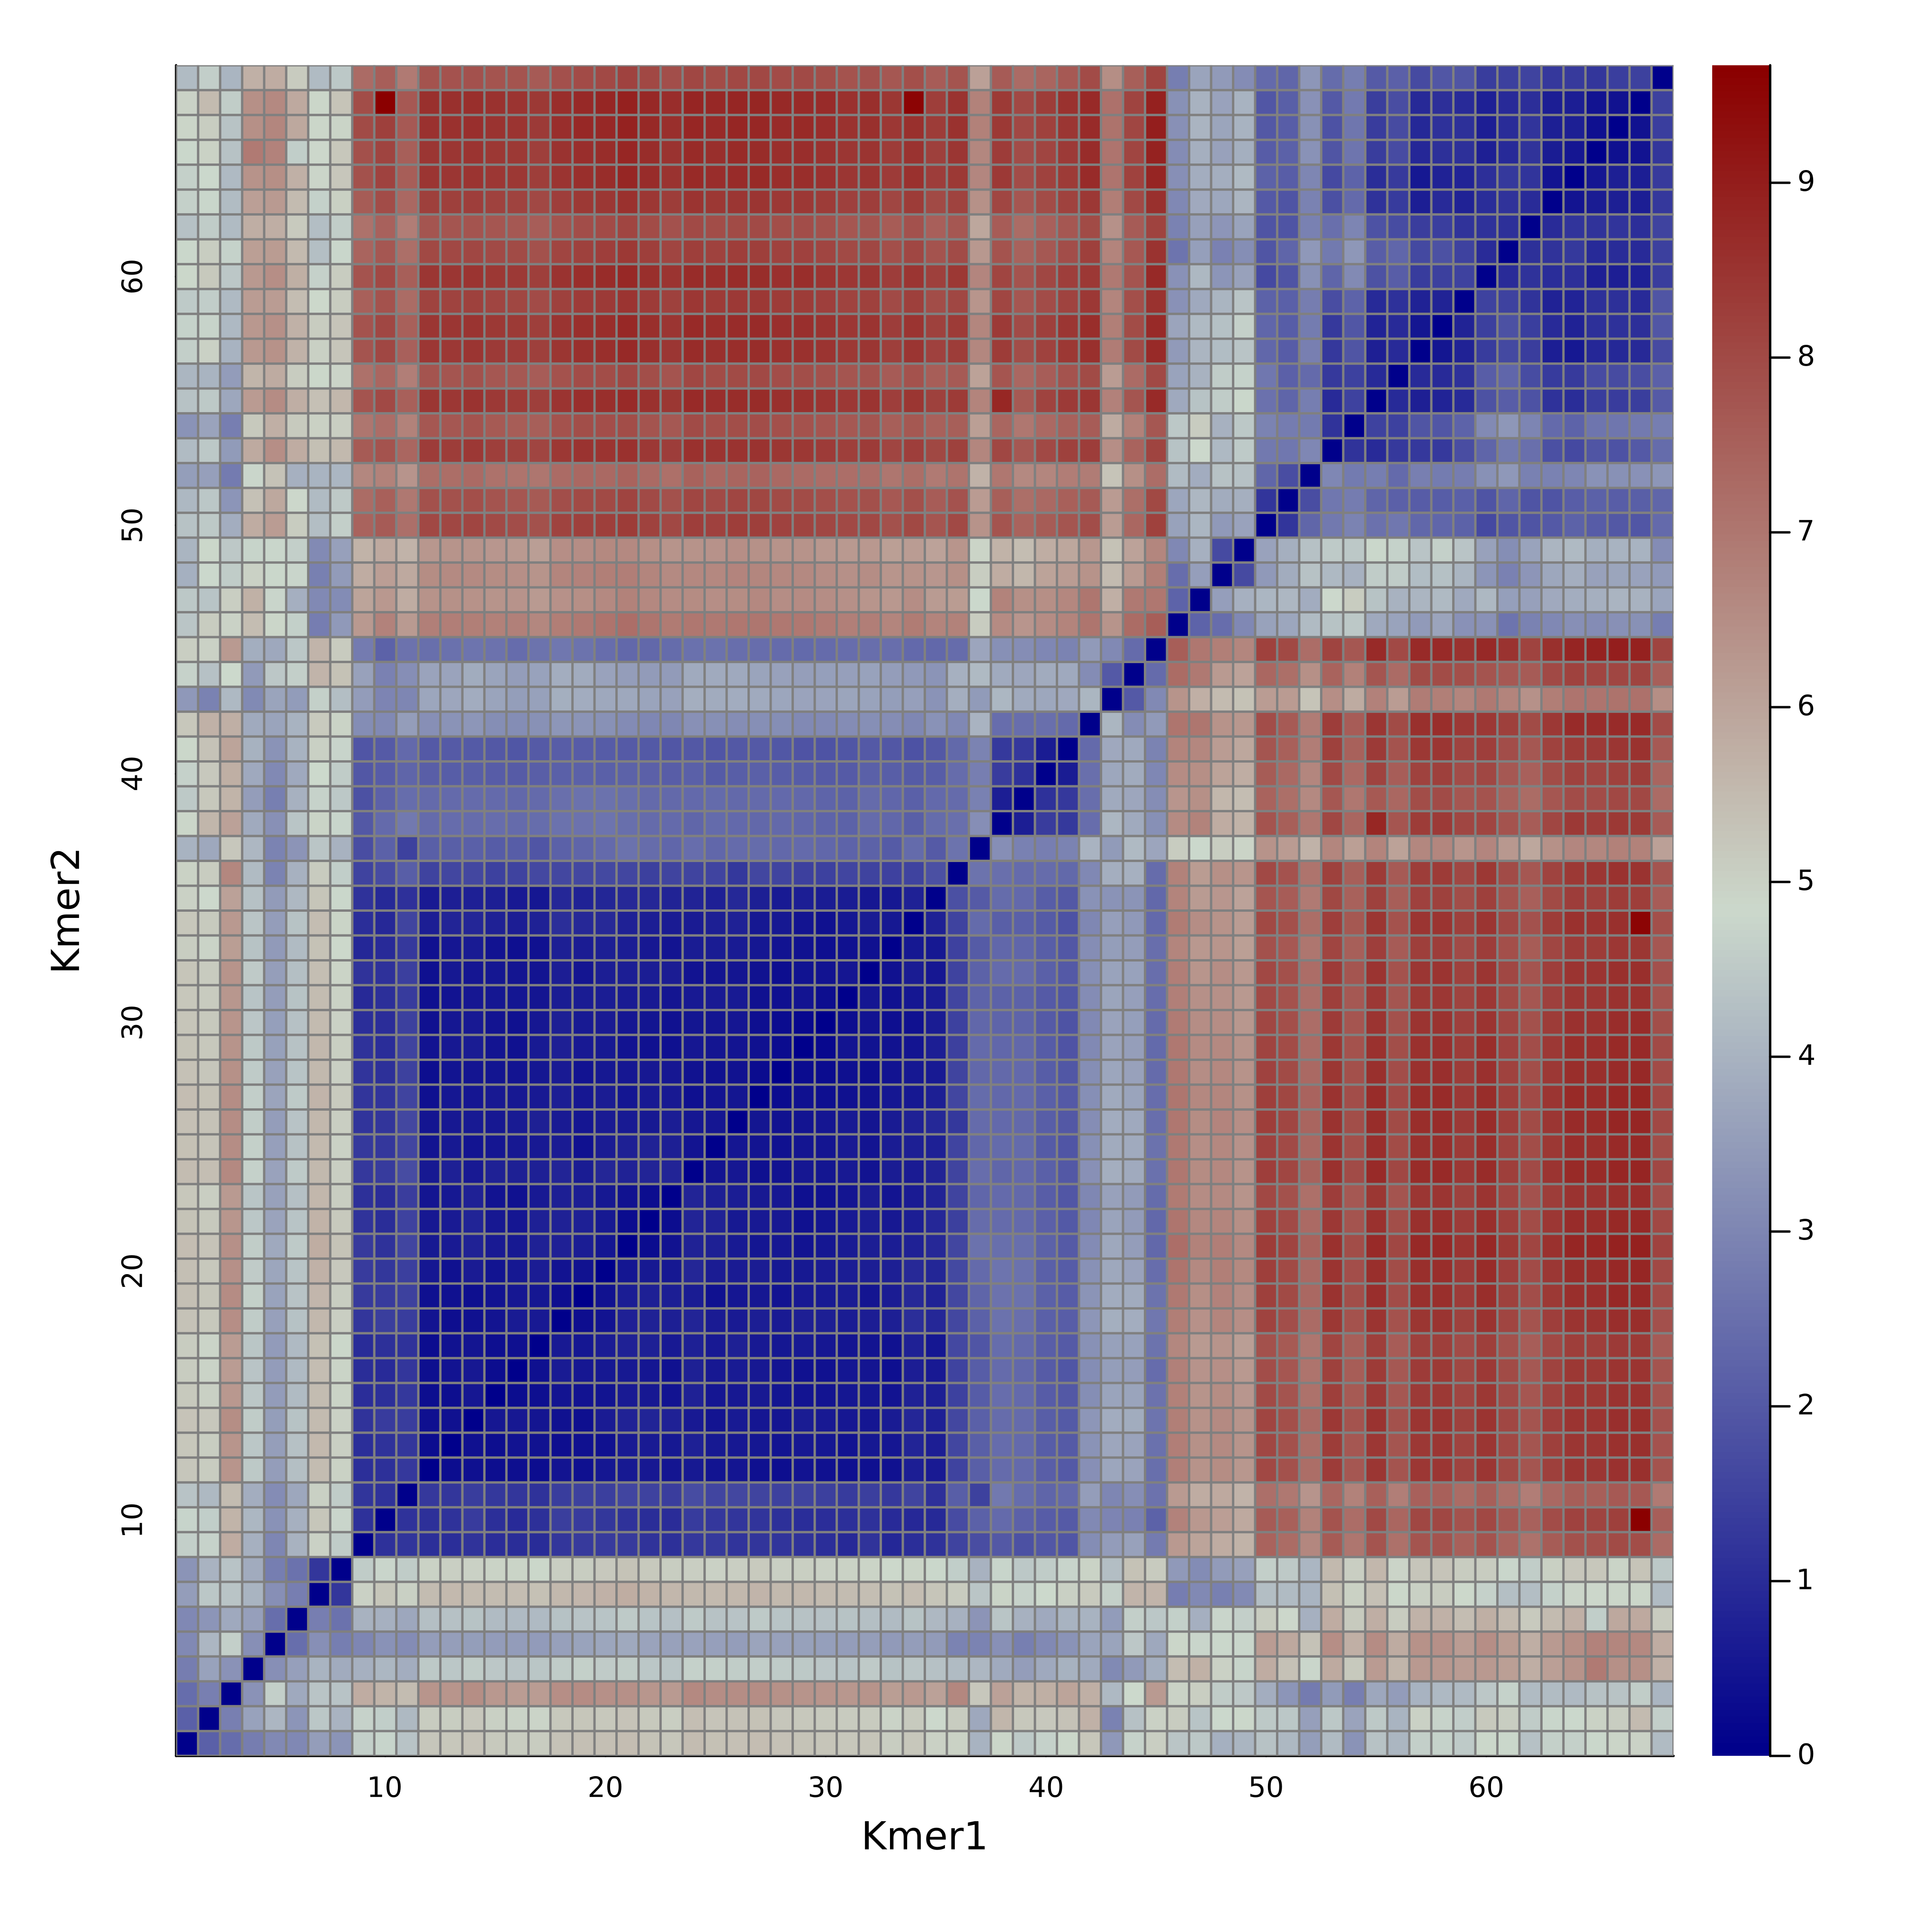

In [101]:
function alphabet_heatmap(m, cmap)
    scale = 12
    i,j = size(m)
    h = heatmap(m, 
        color=cmap,  
        xlabel="Kmer1", ylabel="Kmer2", 
        grid=true, 
        #xticks=(1:10, 1:10:i), yticks=(1:j, 1:10:j), 
        
        size=([i,j] * scale),  
        margins = 5mm,
        dpi=500, yrotation = 90, tickfontsize=8)

    h = vline!(0.5:(j+0.5), c=:grey)
    h = hline!(0.5:(i+0.5), c=:grey, legend=false)
    #savefig("heatmap_3di_vs_AA.png")
    return h
end

morder = reverse(cl.order)
alphabet_heatmap(matrix[morder,morder], :bluesreds)

In [93]:
# dump PDB fragments
pdbfile = "../testpdb/d1914a1.pdb"
outdir =  split(basename(pdbfile), ".")[1]
if isdir(outdir)
    rm(outdir, force = true, recursive=true)
end

mkpath(outdir)



pdb = readpdb_backbone(pdbfile)
pdbfragments = coords2fragments(pdbmatrix, 4)
i = 1
for (cl, frag) in zip(results, pdbfragments)
    writepdb(pdbmatrix2pdb(frag), "$outdir/cl$(cl)frag$i.pdb")
    i+=1
end

In [94]:
unique(results)

22-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
  ⋮
 14
 15
 16
 17
 18
 19
 20
 21
 22